Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Linear RMSE: 0.13215
Ridge RMSE: 0.13645
Lasso RMSE: 0.13796
RandomForest RMSE: 0.14572
XGBoost RMSE: 0.13201


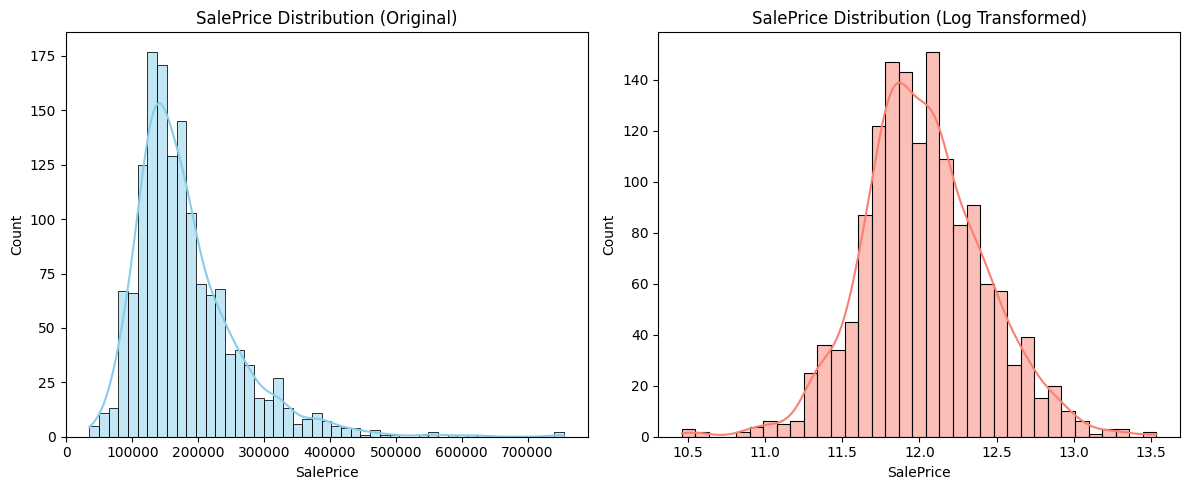

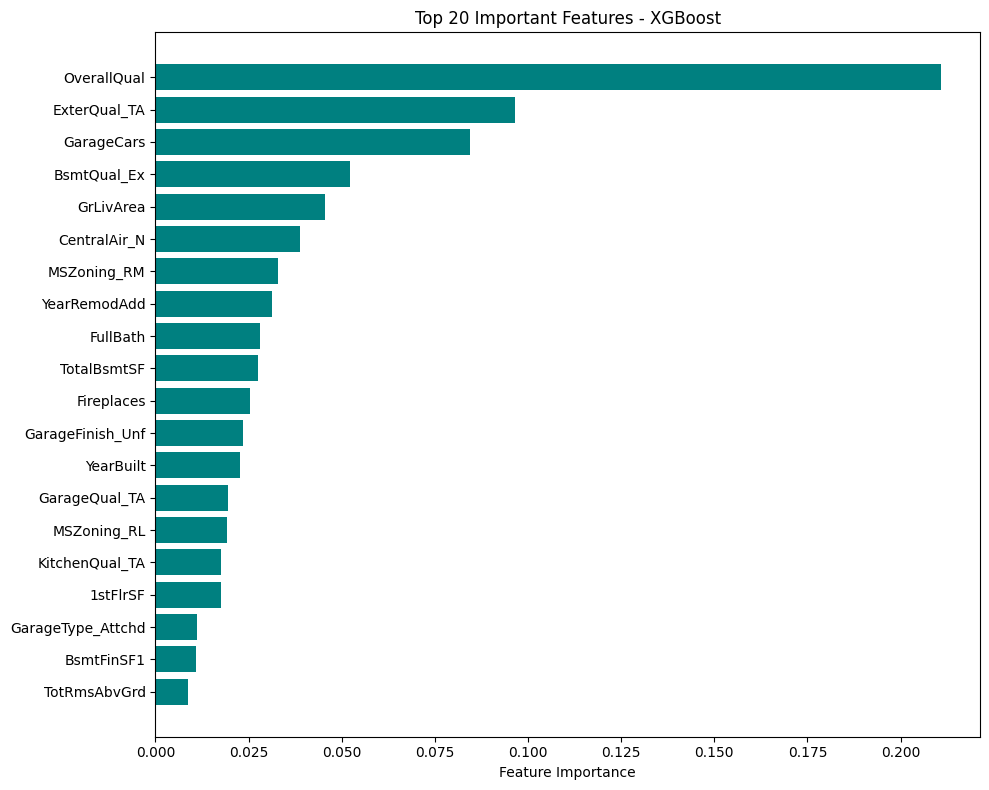

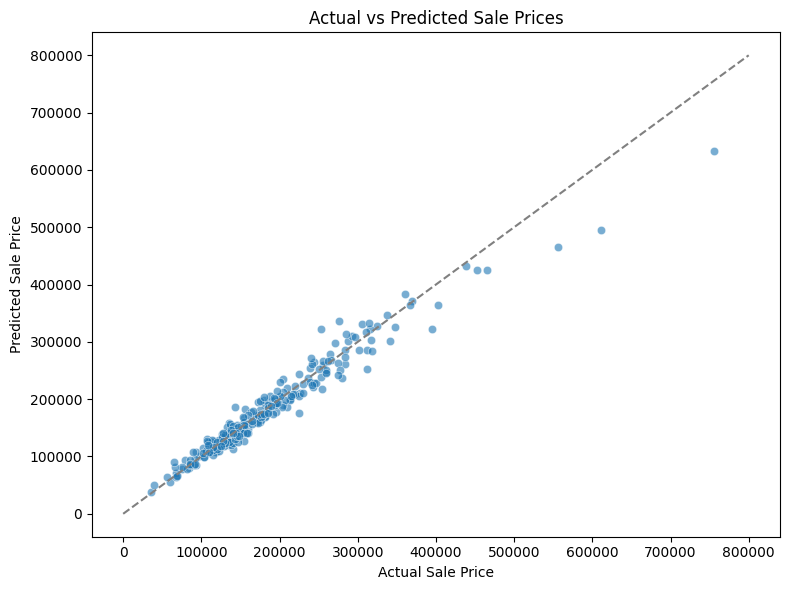

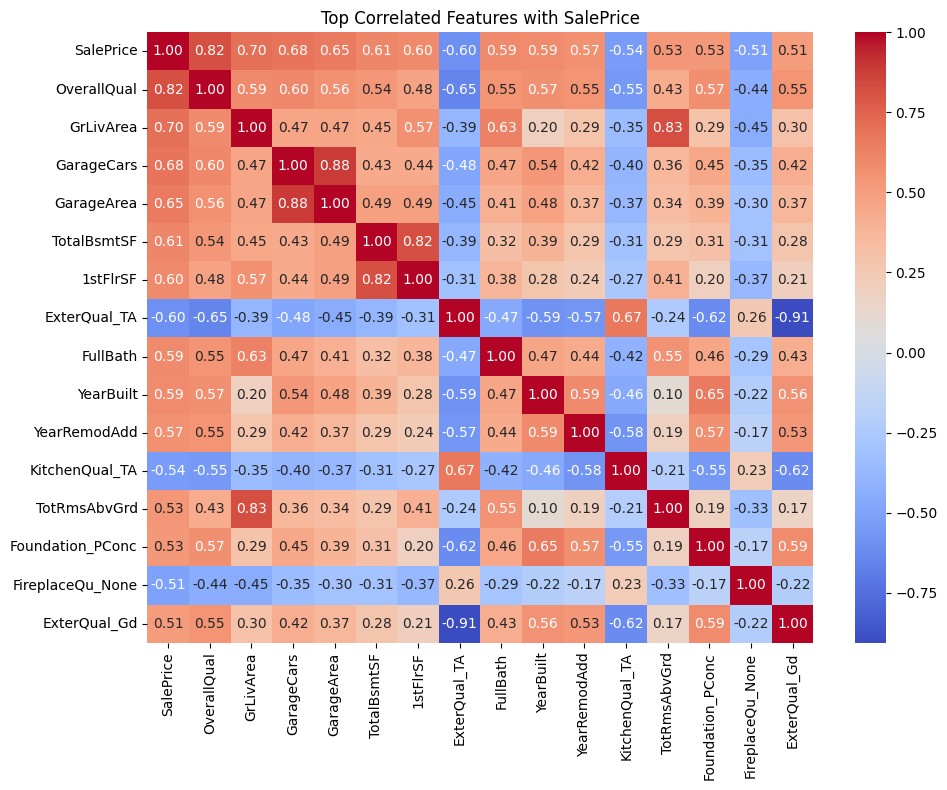

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data from Google Drive
data_path = '/content/drive/MyDrive/Colab Notebooks/ML Project'
train = pd.read_csv(data_path + '/train.csv')
test = pd.read_csv(data_path + '/test.csv')


# Save target and drop Id
train_ID = train['Id']
test_ID = test['Id']
y = train['SalePrice']
train.drop(['SalePrice', 'Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Combine for preprocessing
all_data = pd.concat([train, test], axis=0)

# Fill missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# One-hot encoding
all_data = pd.get_dummies(all_data)

# Split back to train/test
X = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

# Log-transform target
y = np.log1p(y)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=10),
    'Lasso': Lasso(alpha=0.001),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    print(f"{name} RMSE: {rmse:.5f}")

# Final model: XGBoost on full training data
final_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
final_model.fit(X, y)
final_preds = final_model.predict(X_test)
final_preds = np.expm1(final_preds)  # Inverse log transform

# Submission file
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_preds
})
submission.to_csv('submission.csv', index=False)

# ======== 📊 Visualizations for Report ========

# 1. SalePrice Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(np.expm1(y), kde=True, color='skyblue')
plt.title('SalePrice Distribution (Original)')

plt.subplot(1, 2, 2)
sns.histplot(y, kde=True, color='salmon')
plt.title('SalePrice Distribution (Log Transformed)')
plt.tight_layout()
plt.show()

# 2. Feature Importance (Top 20)
importances = final_model.feature_importances_
indices = np.argsort(importances)[-20:]
features = X.columns[indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], color='teal')
plt.yticks(range(len(indices)), features)
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features - XGBoost")
plt.tight_layout()
plt.show()

# 3. Actual vs Predicted
val_preds = final_model.predict(X_val)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.expm1(y_val), y=np.expm1(val_preds), alpha=0.6)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.plot([0, 800000], [0, 800000], '--', color='gray')
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap
corr_matrix = pd.concat([X, y], axis=1).corr()
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(16).index
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_corr, top_corr], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Features with SalePrice")
plt.tight_layout()
plt.show()